In [172]:
!pip install requests tqdm opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [173]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import shutil
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

import time
import math
import warnings
warnings.filterwarnings("ignore")


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [174]:
dataset_path = 'C:/Users/mhe/OneDrive - lamar.edu/LectureNote2023/MLforCivilEng/Assignment-CNN/Image_data'
os.chdir(dataset_path)
os.listdir()
classes = os.listdir(dataset_path)

In [175]:
classes

['0', '1']

In [176]:
df = pd.DataFrame()
for label in tqdm(os.listdir()):    
    os.chdir(label)
    for file in os.listdir():
        try:
            img = cv2.imread(file)
            df = df.append({'class':label, 'filename':file, 'width':img.shape[1], 'height':img.shape[0]}, ignore_index=True)
        except:
            print(os.path.join(label, file), 'Error!')
    os.chdir('../')
os.chdir('../')

100%|██████████| 2/2 [00:22<00:00, 11.09s/it]


In [177]:
df

,class,filename,width,height
0,0,IMG_5161.jpg,1443,1924
1,0,IMG_5162.jpg,3024,4032
2,0,IMG_5164.jpg,1347,1796
3,0,IMG_5166.jpg,2419,1814
4,0,IMG_5172.jpg,3024,4032
...,...,...,...,...
205,1,IMG_5491_2.jpg,2421,1816
206,1,IMG_5492.jpg,3024,4032
207,1,IMG_5492_1.jpg,1761,1321
208,1,IMG_5496.jpg,3024,4032


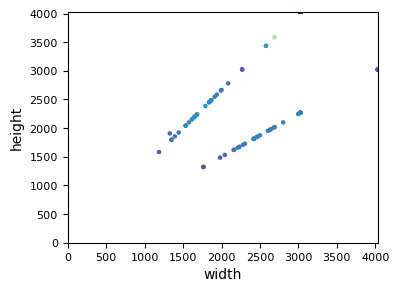

In [178]:
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

x = df['width']
y = df['height']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(4,3))
plt.scatter(x, y, c=z,  s=5, cmap='Spectral_r')

plt.tick_params(labelsize=8)

xy_max = max(max(df['width']), max(df['height']))
plt.xlim(xmin=0, xmax=xy_max)
plt.ylim(ymin=0, ymax=xy_max)

plt.ylabel('height', fontsize=10)
plt.xlabel('width', fontsize=10)

plt.show()

In [179]:
dataset_path_split = 'C:/Users/mhe/OneDrive - lamar.edu/LectureNote2023/MLforCivilEng/Assignment-CNN/SplitDataset'
# create train folder
os.mkdir(os.path.join(dataset_path_split, 'train'))
# create test folder
os.mkdir(os.path.join(dataset_path_split, 'test'))

# create 0 and 1 folders in train and test folders respectively
for label in classes:
    os.mkdir(os.path.join(dataset_path_split, 'train', label))
    os.mkdir(os.path.join(dataset_path_split, 'test', label))

In [180]:
test_frac = 0.2 
random.seed(123) 

In [181]:
df1 = pd.DataFrame()

for label in classes:

    # Read all image filenames for this label
    old_dir = os.path.join(dataset_path, label)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # shuffle randomly

    # split training and test sets
    testset_numer = int(len(images_filename) * test_frac) # number of images in test set
    testset_images = images_filename[:testset_numer] 
    trainset_images = images_filename[testset_numer:] 

    # move images to test folder
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, label, image)   # original folder path
        new_test_path = os.path.join(dataset_path_split, 'test', label, image) # test folder path
        shutil.move(old_img_path, new_test_path) 

    # move images to train folder
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, label, image)   # original folder path
        new_train_path = os.path.join(dataset_path_split, 'train', label, image) # train folder path
        shutil.move(old_img_path, new_train_path) 
    
    # check if all images have been moved
    assert len(os.listdir(old_dir)) == 0
    print('Done!')
    
    # Save the number of data for each category into the table
    df1 = df1.append({'class':label, 'trainset':len(trainset_images), 'testset':len(testset_images)}, ignore_index=True)

Done!
Done!


In [184]:
# Statistical table of the number of categories in the data set
df1['total'] = df1['trainset'] + df1['testset']
df1

,class,trainset,testset,total
0,0,72,18,90
1,1,96,24,120


In [185]:
# Visualize images
folder_path = 'C:/Users/mhe/OneDrive - lamar.edu/LectureNote2023/MLforCivilEng/Assignment-CNN/SplitDataset/train/1'
N = 25
n = math.floor(np.sqrt(N))
n

5

In [186]:
# read all images in the folder
images = []
for each_img in os.listdir(folder_path)[:N]:
    img_path = os.path.join(folder_path, each_img)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)

In [187]:
len(images)

25

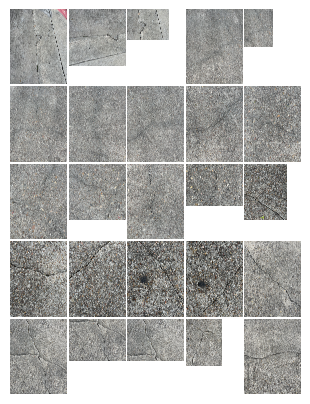

In [188]:
fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(n, n), 
                 axes_pad=0.02, 
                 share_all=True
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)
    ax.axis('off')

plt.show()

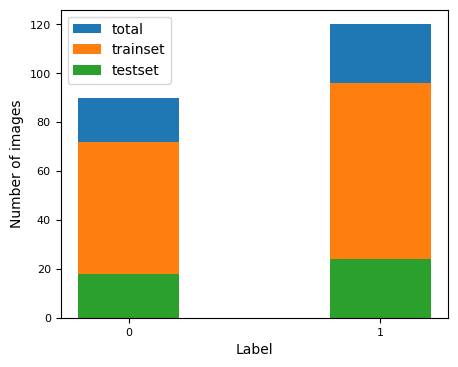

In [190]:
plt.figure(figsize=(5, 4))
x = df1['class']
y1 = df1['total']
y2 = df1['trainset']
y3 = df1['testset']

width = 0.4

plt.bar(x, y1, width, label='total')
plt.bar(x, y2, width, label='trainset', bottom=0)
plt.bar(x, y3, width, label='testset', bottom=0)

plt.xlabel('Label', fontsize=10)
plt.ylabel('Number of images', fontsize=10)
plt.tick_params(labelsize=8)

plt.legend(fontsize=10)

plt.show()

In [215]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


In [216]:
# image preprocess
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485,0.456,0.406],
                                         std=[0.229,0.224,0.225])
                                     ])

In [217]:
dataset_dir = 'SplitDataset'

In [218]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'test')
train_dataset = datasets.ImageFolder(train_path, train_transform)
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [219]:
print('Number of images in training set:', len(train_dataset))
print('Labels:', train_dataset.classes)

Number of images in training set: 168
Labels: ['0', '1']


In [220]:
print('Number of images in test set:', len(test_dataset))
print('Labels:', test_dataset.classes)

Number of images in test set: 42
Labels: ['0', '1']


In [221]:
class_to_index = train_dataset.class_to_idx
np.save('labels_to_index.npy',class_to_index)
print('Index of labels:',class_to_index)

Index of labels: {'0': 0, '1': 1}


In [222]:
# define dataloader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True
                         )
test_loader = DataLoader(test_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False
                         )

In [223]:
# check the images and labels in one batch
images, labels = next(iter(train_loader))

In [224]:
images.shape # torch.Size([batch size, RGB channels=3, size=224,224])

torch.Size([64, 3, 224, 224])

In [225]:
labels

tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1])

In [226]:
# visulization
images_np = images.numpy()
images_np[0].shape

(3, 224, 224)

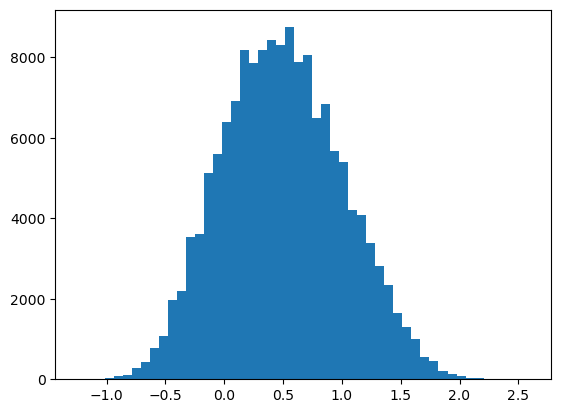

In [227]:
plt.hist(images_np[0].flatten(),bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


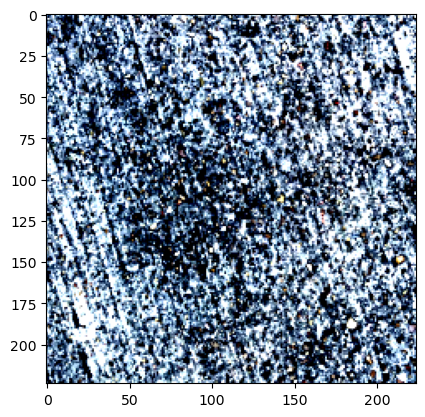

In [228]:
# check preprosessed images
plt.imshow(images_np[0].transpose((1,2,0))) # transpose to (224,224,3)

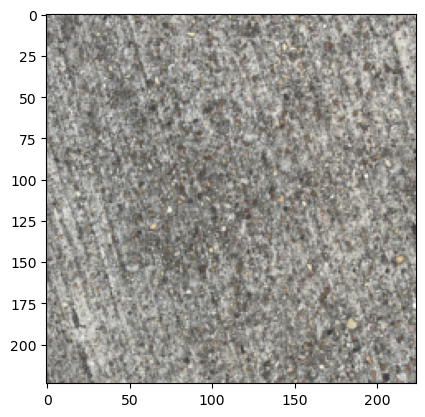

In [229]:
# original images
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])
plt.imshow(np.clip(images_np[0].transpose((1,2,0))*std+mean, 0,1))
plt.show()

In [242]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 2) # 2 labels
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #print(x.shape) # torch.Size([64, 64, 56, 56])
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNmodel().to(device)

# The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model. 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=5e-4)

In [243]:
# train loop
epochs = 2000
time_list = []
train_loss_list = []
for epoch in range(epochs):
    train_loss = []
    start_time = time.time()
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
 
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss.append(float(loss.data.mean()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss_list.append(np.mean(train_loss))
    total_time = time.time() - start_time
    time_list.append(total_time)
    
    print('Epoch %d loss: %.3f' % (epoch, np.mean(train_loss)))


Epoch 0 loss: 0.691
Epoch 1 loss: 0.687
Epoch 2 loss: 0.686
Epoch 3 loss: 0.686
Epoch 4 loss: 0.690
Epoch 5 loss: 0.686
Epoch 6 loss: 0.687
Epoch 7 loss: 0.686
Epoch 8 loss: 0.686
Epoch 9 loss: 0.685
Epoch 10 loss: 0.684
Epoch 11 loss: 0.687
Epoch 12 loss: 0.684
Epoch 13 loss: 0.688
Epoch 14 loss: 0.684
Epoch 15 loss: 0.686
Epoch 16 loss: 0.687
Epoch 17 loss: 0.688
Epoch 18 loss: 0.685
Epoch 19 loss: 0.684
Epoch 20 loss: 0.688
Epoch 21 loss: 0.684
Epoch 22 loss: 0.683
Epoch 23 loss: 0.688
Epoch 24 loss: 0.688
Epoch 25 loss: 0.685
Epoch 26 loss: 0.684
Epoch 27 loss: 0.687
Epoch 28 loss: 0.685
Epoch 29 loss: 0.686
Epoch 30 loss: 0.682
Epoch 31 loss: 0.683
Epoch 32 loss: 0.684
Epoch 33 loss: 0.682
Epoch 34 loss: 0.685
Epoch 35 loss: 0.683
Epoch 36 loss: 0.685
Epoch 37 loss: 0.685
Epoch 38 loss: 0.684
Epoch 39 loss: 0.686
Epoch 40 loss: 0.684
Epoch 41 loss: 0.680
Epoch 42 loss: 0.685
Epoch 43 loss: 0.680
Epoch 44 loss: 0.683
Epoch 45 loss: 0.684
Epoch 46 loss: 0.680
Epoch 47 loss: 0.678
Ep

Epoch 378 loss: 0.669
Epoch 379 loss: 0.668
Epoch 380 loss: 0.672
Epoch 381 loss: 0.675
Epoch 382 loss: 0.668
Epoch 383 loss: 0.677
Epoch 384 loss: 0.660
Epoch 385 loss: 0.670
Epoch 386 loss: 0.665
Epoch 387 loss: 0.660
Epoch 388 loss: 0.671
Epoch 389 loss: 0.680
Epoch 390 loss: 0.665
Epoch 391 loss: 0.663
Epoch 392 loss: 0.671
Epoch 393 loss: 0.671
Epoch 394 loss: 0.673
Epoch 395 loss: 0.672
Epoch 396 loss: 0.669
Epoch 397 loss: 0.665
Epoch 398 loss: 0.673
Epoch 399 loss: 0.674
Epoch 400 loss: 0.671
Epoch 401 loss: 0.669
Epoch 402 loss: 0.668
Epoch 403 loss: 0.667
Epoch 404 loss: 0.666
Epoch 405 loss: 0.671
Epoch 406 loss: 0.669
Epoch 407 loss: 0.666
Epoch 408 loss: 0.669
Epoch 409 loss: 0.663
Epoch 410 loss: 0.669
Epoch 411 loss: 0.672
Epoch 412 loss: 0.668
Epoch 413 loss: 0.671
Epoch 414 loss: 0.672
Epoch 415 loss: 0.669
Epoch 416 loss: 0.671
Epoch 417 loss: 0.676
Epoch 418 loss: 0.672
Epoch 419 loss: 0.662
Epoch 420 loss: 0.667
Epoch 421 loss: 0.669
Epoch 422 loss: 0.666
Epoch 423 

Epoch 751 loss: 0.661
Epoch 752 loss: 0.654
Epoch 753 loss: 0.665
Epoch 754 loss: 0.665
Epoch 755 loss: 0.663
Epoch 756 loss: 0.671
Epoch 757 loss: 0.662
Epoch 758 loss: 0.658
Epoch 759 loss: 0.667
Epoch 760 loss: 0.656
Epoch 761 loss: 0.667
Epoch 762 loss: 0.667
Epoch 763 loss: 0.666
Epoch 764 loss: 0.663
Epoch 765 loss: 0.660
Epoch 766 loss: 0.665
Epoch 767 loss: 0.659
Epoch 768 loss: 0.662
Epoch 769 loss: 0.672
Epoch 770 loss: 0.662
Epoch 771 loss: 0.666
Epoch 772 loss: 0.664
Epoch 773 loss: 0.665
Epoch 774 loss: 0.662
Epoch 775 loss: 0.665
Epoch 776 loss: 0.658
Epoch 777 loss: 0.665
Epoch 778 loss: 0.670
Epoch 779 loss: 0.667
Epoch 780 loss: 0.654
Epoch 781 loss: 0.662
Epoch 782 loss: 0.678
Epoch 783 loss: 0.672
Epoch 784 loss: 0.642
Epoch 785 loss: 0.665
Epoch 786 loss: 0.657
Epoch 787 loss: 0.664
Epoch 788 loss: 0.663
Epoch 789 loss: 0.664
Epoch 790 loss: 0.663
Epoch 791 loss: 0.654
Epoch 792 loss: 0.667
Epoch 793 loss: 0.661
Epoch 794 loss: 0.665
Epoch 795 loss: 0.677
Epoch 796 

Epoch 1119 loss: 0.649
Epoch 1120 loss: 0.666
Epoch 1121 loss: 0.660
Epoch 1122 loss: 0.658
Epoch 1123 loss: 0.657
Epoch 1124 loss: 0.659
Epoch 1125 loss: 0.675
Epoch 1126 loss: 0.657
Epoch 1127 loss: 0.653
Epoch 1128 loss: 0.652
Epoch 1129 loss: 0.660
Epoch 1130 loss: 0.660
Epoch 1131 loss: 0.661
Epoch 1132 loss: 0.663
Epoch 1133 loss: 0.654
Epoch 1134 loss: 0.657
Epoch 1135 loss: 0.652
Epoch 1136 loss: 0.656
Epoch 1137 loss: 0.657
Epoch 1138 loss: 0.664
Epoch 1139 loss: 0.662
Epoch 1140 loss: 0.647
Epoch 1141 loss: 0.657
Epoch 1142 loss: 0.666
Epoch 1143 loss: 0.656
Epoch 1144 loss: 0.663
Epoch 1145 loss: 0.657
Epoch 1146 loss: 0.659
Epoch 1147 loss: 0.657
Epoch 1148 loss: 0.652
Epoch 1149 loss: 0.654
Epoch 1150 loss: 0.652
Epoch 1151 loss: 0.666
Epoch 1152 loss: 0.663
Epoch 1153 loss: 0.647
Epoch 1154 loss: 0.658
Epoch 1155 loss: 0.662
Epoch 1156 loss: 0.655
Epoch 1157 loss: 0.658
Epoch 1158 loss: 0.649
Epoch 1159 loss: 0.648
Epoch 1160 loss: 0.647
Epoch 1161 loss: 0.661
Epoch 1162 

Epoch 1476 loss: 0.659
Epoch 1477 loss: 0.641
Epoch 1478 loss: 0.656
Epoch 1479 loss: 0.659
Epoch 1480 loss: 0.643
Epoch 1481 loss: 0.648
Epoch 1482 loss: 0.650
Epoch 1483 loss: 0.640
Epoch 1484 loss: 0.652
Epoch 1485 loss: 0.657
Epoch 1486 loss: 0.655
Epoch 1487 loss: 0.651
Epoch 1488 loss: 0.655
Epoch 1489 loss: 0.658
Epoch 1490 loss: 0.657
Epoch 1491 loss: 0.648
Epoch 1492 loss: 0.650
Epoch 1493 loss: 0.658
Epoch 1494 loss: 0.653
Epoch 1495 loss: 0.648
Epoch 1496 loss: 0.648
Epoch 1497 loss: 0.654
Epoch 1498 loss: 0.651
Epoch 1499 loss: 0.650
Epoch 1500 loss: 0.650
Epoch 1501 loss: 0.652
Epoch 1502 loss: 0.645
Epoch 1503 loss: 0.645
Epoch 1504 loss: 0.652
Epoch 1505 loss: 0.642
Epoch 1506 loss: 0.644
Epoch 1507 loss: 0.662
Epoch 1508 loss: 0.661
Epoch 1509 loss: 0.657
Epoch 1510 loss: 0.652
Epoch 1511 loss: 0.638
Epoch 1512 loss: 0.649
Epoch 1513 loss: 0.651
Epoch 1514 loss: 0.659
Epoch 1515 loss: 0.643
Epoch 1516 loss: 0.640
Epoch 1517 loss: 0.639
Epoch 1518 loss: 0.647
Epoch 1519 

Epoch 1833 loss: 0.635
Epoch 1834 loss: 0.656
Epoch 1835 loss: 0.646
Epoch 1836 loss: 0.631
Epoch 1837 loss: 0.638
Epoch 1838 loss: 0.641
Epoch 1839 loss: 0.639
Epoch 1840 loss: 0.652
Epoch 1841 loss: 0.646
Epoch 1842 loss: 0.652
Epoch 1843 loss: 0.658
Epoch 1844 loss: 0.650
Epoch 1845 loss: 0.633
Epoch 1846 loss: 0.655
Epoch 1847 loss: 0.646
Epoch 1848 loss: 0.640
Epoch 1849 loss: 0.659
Epoch 1850 loss: 0.643
Epoch 1851 loss: 0.643
Epoch 1852 loss: 0.642
Epoch 1853 loss: 0.646
Epoch 1854 loss: 0.649
Epoch 1855 loss: 0.647
Epoch 1856 loss: 0.652
Epoch 1857 loss: 0.643
Epoch 1858 loss: 0.639
Epoch 1859 loss: 0.649
Epoch 1860 loss: 0.642
Epoch 1861 loss: 0.641
Epoch 1862 loss: 0.635
Epoch 1863 loss: 0.641
Epoch 1864 loss: 0.635
Epoch 1865 loss: 0.642
Epoch 1866 loss: 0.663
Epoch 1867 loss: 0.655
Epoch 1868 loss: 0.663
Epoch 1869 loss: 0.641
Epoch 1870 loss: 0.646
Epoch 1871 loss: 0.634
Epoch 1872 loss: 0.625
Epoch 1873 loss: 0.647
Epoch 1874 loss: 0.637
Epoch 1875 loss: 0.635
Epoch 1876 

In [244]:
# test
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy on test set: %d%%' % (100*correct/total))

Accuracy on test set: 61%


In [245]:
# accuracy on training set
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy on training set: %d%%' % (100*correct/total))

Accuracy on training set: 60%


Total training time: 36763.76254034042
Average training time: 18.38188127017021


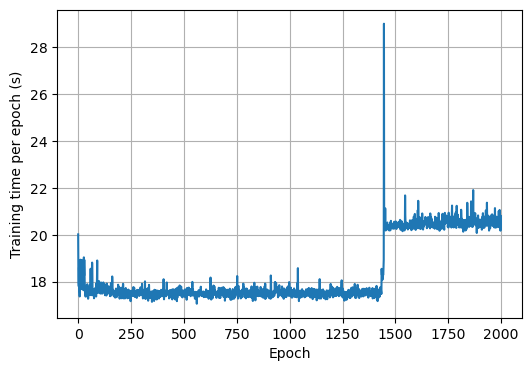

In [246]:
x = np.linspace(0.0, epochs-1, epochs)

print('Total training time:', sum(time_list))
print('Average training time:', sum(time_list)/epochs)
plt.figure(figsize=(6,4))
plt.xlabel('Epoch')
plt.ylabel('Training time per epoch (s)')
plt.plot(x, time_list)
plt.grid()

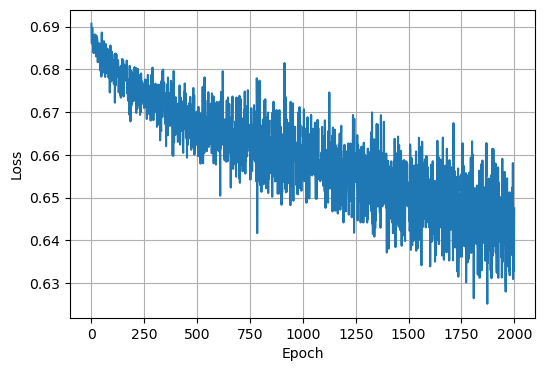

In [247]:
x = np.linspace(0.0, epochs-1, epochs)

plt.figure(figsize=(6,4))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss_list)
plt.grid()